
## Delta GPTs - (Train on 100, 200, 300 and predict the next 20)

* Delta: SI differences
* compare 100 to 200 to 300
* Written to run on GPU
* Long train so best run on GPU


In [1]:

##!pip install xgboost
## !pip install matplotlib
## !pip install scikit-learn
## !pip install einops


In [2]:

import pandas as pd
import numpy as np


In [3]:

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [4]:

## import xgboost as xgb
## from xgboost import XGBClassifier, XGBRegressor, DMatrix, train as train_xgb


In [5]:


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import torch
import pandas as pd
import sklearn
import random
import math


In [6]:

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

## coefficient of determination 
from sklearn.metrics import r2_score



## Univariate permutation example


In [7]:

from einops import rearrange
from math import sqrt, log


In [8]:

patch_size = 10
stride     = 4

x_enc = torch.rand( 8, 40, 24)
print( x_enc.shape )

B, L, M = x_enc.shape
print(B)
print(L)
print(M)

x_enc = rearrange(x_enc, 'b l m -> b m l')
print( x_enc.shape )

x_enc = x_enc.unfold(dimension=-1, size=patch_size, step=stride)
print( x_enc.shape )

x_enc = rearrange(x_enc, 'b m n p -> (b m) n p')
x_enc.shape


torch.Size([8, 40, 24])
8
40
24
torch.Size([8, 24, 40])
torch.Size([8, 24, 8, 10])


torch.Size([192, 8, 10])


## Positional Encoding example


In [9]:

def PositionalEncoding(q_len, d_model, normalize=True):
    pe = torch.zeros(q_len, d_model)
    position = torch.arange(0, q_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    if normalize:
        pe = pe - pe.mean()
        pe = pe / (pe.std() * 10)
    return pe


In [10]:

res = PositionalEncoding(15, 512, normalize=True)
res.shape


torch.Size([15, 512])

In [11]:

device = "cpu"


In [12]:

x_enc = torch.rand( 8, 15, 512)
print( x_enc.shape )


torch.Size([8, 15, 512])


In [13]:

pos_emb_table_rc         = nn.Embedding(15, 512)     ## [15, 512]


In [14]:

torch.arange(15, device=device)



tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [15]:

pos_emb = pos_emb_table_rc( torch.arange(15, device=device) ) 


In [16]:

pos_emb.shape


torch.Size([15, 512])

In [17]:

res = x_enc + pos_emb


In [18]:

res.shape


torch.Size([8, 15, 512])


## Moving Avg example


In [19]:

'''

class moving_avg(nn.Module):

    def __init__(self, x):
        
        super().__init__()
        
        self.kernel_size = x.shape[2]
        self.stride      = 1
        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)

    def forward(self, x):
        

        x = self.avg( x )         ## x.permute(0, 2, 1))
        
        ## x = x.permute(0, 2, 1)
        
        return x

'''


'\n\nclass moving_avg(nn.Module):\n\n    def __init__(self, x):\n        \n        super().__init__()\n        \n        self.kernel_size = x.shape[2]\n        self.stride      = 1\n        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)\n\n    def forward(self, x):\n        \n\n        x = self.avg( x )         ## x.permute(0, 2, 1))\n        \n        ## x = x.permute(0, 2, 1)\n        \n        return x\n\n'

In [20]:

'''

x_enc = torch.rand( 8, 40, 5)

print( x_enc.shape )

obj_mov_avg = moving_avg( x_enc  )

res = obj_mov_avg( x_enc )

print( x_enc[1, 2, :])

ans = x_enc - res

print( ans[1, 2, :])

print( ans.shape )

'''



'\n\nx_enc = torch.rand( 8, 40, 5)\n\nprint( x_enc.shape )\n\nobj_mov_avg = moving_avg( x_enc  )\n\nres = obj_mov_avg( x_enc )\n\nprint( x_enc[1, 2, :])\n\nans = x_enc - res\n\nprint( ans[1, 2, :])\n\nprint( ans.shape )\n\n'


## Read the data


In [21]:

for_RNN_data_CIVS = pd.read_csv('input/RNN_time_DELAYS_2000_PerCast_rcalix.csv')


In [22]:

for_RNN_data_CIVS


,Unnamed: 0,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,...,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,1,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,...,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,2,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,...,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,3,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,...,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,4,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,...,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,5,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,...,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,1379,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,...,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,1380,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,...,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,1381,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,...,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,1382,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,...,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [23]:

cols_list_DF = for_RNN_data_CIVS.columns.values.tolist()
cols_list_DF


['Unnamed: 0',
 'SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']

In [24]:

l_new = ['SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']


In [25]:

for_RNN_data_CIVS = for_RNN_data_CIVS[l_new]


In [26]:

for_RNN_data_CIVS 


,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,...,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,...,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,...,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,...,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,...,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,...,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,...,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,...,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,...,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,...,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0



## Plots


In [27]:

plt.rcParams["figure.figsize"] = [15, 5]


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

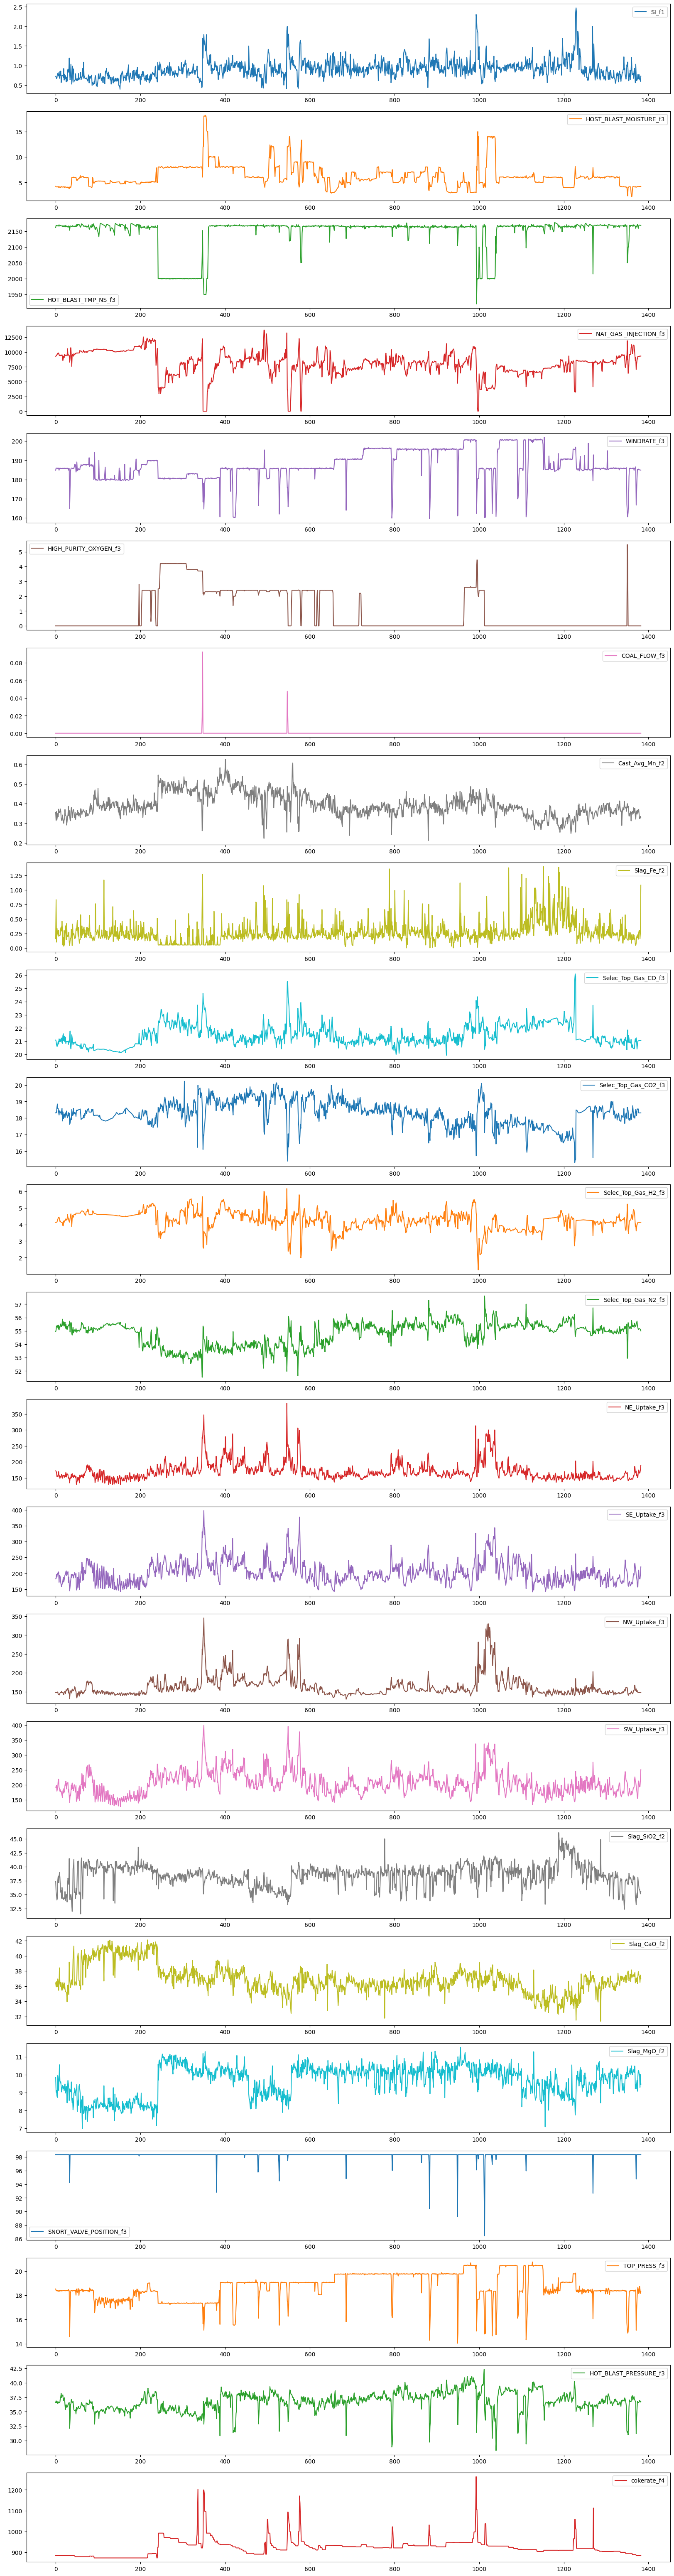

In [28]:

for_RNN_data_CIVS.plot( kind='line', subplots=True, figsize=(20,80),
        sharex=False, sharey=False, legend=True )


In [29]:

print(for_RNN_data_CIVS.shape)


(1383, 24)



## Parameters


In [30]:

pd.options.display.max_columns = None



## Standardize (Scaling)


In [31]:

def standardize_x_scales( data_gpt_pd ):


    data_gpt = torch.tensor(data_gpt_pd.values).float()
        
    epsilon = 0.0001

    print( data_gpt.shape)        
    
    x_means      = data_gpt .mean(0,  keepdim=True)
    x_deviations = data_gpt .std( 0,  keepdim=True) + epsilon

    ## x_train_tr_scaled = (x_train_tr - x_means) / x_deviations
    ## y_test_tr_scaled  = (y_test_tr  - y_means) / y_deviations
    
    return data_gpt, x_means, x_deviations


In [32]:

## x_means      = simple_x_train.mean(0, keepdim=True ) 
## x_deviations = simple_x_train.std( 0, keepdim=True) + epsilon



## Shift and create batches


In [33]:

def get_batch( data_gpt ):
    
    ix = torch.randint(   len(data_gpt) - block_size, (batch_size,)   )

    ## ix = [ int( tensor1.item() ) for tensor1 in ix ]
    ## print(ix.shape)
    ## print(ix)
    ## print(ix[1])
    ## print(  type(ix[1])  )
    ## print( len(data_gpt) - block_size )
    ## print(  block_size )
    ## print(  (batch_size,)  )
    
    x  = torch.stack(    [  data_gpt[   i   : i+block_size    ]   for i in ix ]    ) 
    y  = torch.stack(    [  data_gpt[   i+1 : i+1+block_size  ]   for i in ix ]    )
    
    x, y = x.to(device), y.to(device)

    return x, y


In [34]:

'''

train_CIVS_tr, x_means, x_standard_devs = standardize_x_scales( train_CIVS )

train_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs

bt_train_x, bt_train_y = get_batch( train_CIVS_tr_scaled )

bt_train_x.shape

bt_train_y.shape

x_means

'''


'\n\ntrain_CIVS_tr, x_means, x_standard_devs = standardize_x_scales( train_CIVS )\n\ntrain_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs\n\nbt_train_x, bt_train_y = get_batch( train_CIVS_tr_scaled )\n\nbt_train_x.shape\n\nbt_train_y.shape\n\nx_means\n\n'


## Estimate loss - No Training


In [35]:

@torch.no_grad()    ## for efficient processing
def estimate_loss( model, criterion ):
    
    out = {}
    model.eval()   ## set to no training
    
    for split in ['train', 'test']:
        losses = torch.zeros(eval_iters)
        for k in range( eval_iters ):
            X, Y = get_batch( split )
            logits  = model(X, Y)
            B, T, E  = logits.shape
            pred     = logits.view( B*T, E)
            y_train  = Y.view(B*T, E)
            loss =  criterion( pred, y_train )
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()  ## back to training

    return out



## NN Architectures


In [36]:

class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        
        self.key   = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]
        self.query = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]
        self.value = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]

        tril_def = torch.tril( torch.ones(block_size, block_size) )  ## [40, 40]
        
        self.register_buffer(
                  'tril', 
                  tril_def
               )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        
        B, T, E = x.shape   ## [batch_size, 40, 512]
        
        k = self.key(   x )            ## k = (B, T, 64)
        q = self.query( x )            ## q = (B, T, 64)

        E2 = 64     ## I think this is 64 and not 512
        ## (B, T, E) @ (B, E, T)  -> (B, T, T)
        wei = q @ k.transpose(-2, -1) * E2 ** -0.5        
        
        wei = wei.masked_fill(
                      self.tril[:T, :T] == 0, 
                      float('-inf')
        )   
        
        ## (B, T, T)
        wei = F.softmax( wei, dim= -1 )         ## (B, T, T)
        wei = self.dropout(   wei   )
        
        ## perform weighted aggregation of values
        
        v   = self.value(  x  )   ## x = (B, 40, E)
        out = wei @ v             ## (B, T, T) @ (B, T, 64) -> (B, T, 64)
        
        return out
        


In [37]:

class FeedForward(nn.Module):

    def __init__(self, n_embd):         ## 512
        
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),      ## [512, 4*512]
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),      ## [4*512, 512]
            nn.Dropout(dropout),
        )
        
    def forward(self, x):
        return self.net(x)


In [38]:

class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size):    ## (8, 64)
        super().__init__()
        self.heads = nn.ModuleList(  [ Head(head_size) for _ in range(num_heads) ] )
        self.proj  = nn.Linear(n_embd, n_embd)   ## 512, 512
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out = torch.cat(   [ h(x) for h in self.heads ], dim = -1   )
        out = self.proj(  out   )
        out = self.dropout(   out   )
        return out


In [39]:

class Block(nn.Module):
    
    def __init__(self, n_embd, n_head):     ## (512, 8)
        super().__init__()
        head_size = n_embd // n_head        ## 64
        self.sa   = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward( n_embd)    ## 512
        self.ln1  = nn.LayerNorm(n_embd)
        self.ln2  = nn.LayerNorm(n_embd)
        
    def forward(self, x):
        x = x + self.sa(     self.ln1(x)      )
        x = x + self.ffwd(   self.ln2(x)      )
        return x


In [40]:

class moving_avg(nn.Module):

    def __init__(self, x):
        
        super().__init__()
        
        self.kernel_size = x.shape[2]
        self.stride      = 1
        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)

    def forward(self, x):
        

        x = self.avg( x )         ## x.permute(0, 2, 1))
        
        ## x = x.permute(0, 2, 1)
        
        return x


In [41]:

class Time_Series_GPT(nn.Module):
    
    def __init__(self, seq_length, input_size, output_size):
        
        super().__init__()
        
        self.output_size= output_size
        self.seq_length = seq_length
        self.input_size = input_size

        
        ## self.token_embedding_table = nn.Embedding(vocab_size, n_embd)   ## [65, 512]
        self.pos_emb_table         = nn.Embedding(block_size, n_embd)     ## [block, 512]
        
        self.blocks = nn.Sequential(
                *[   Block(n_embd, n_head=n_head) for _ in range(n_layer)    ]
        )
        
        self.ln_f        = nn.LayerNorm(  n_embd    )        
        self.lm_ffw_head = nn.Linear(n_embd, 25)  ## [512, 65] # FFW Layer

        self.map_24_512 = nn.Linear(25, 512)  ## [24, 512] # rc remove
        self.map_act    = nn.ReLU()

        self.map_permute1 = nn.Linear( 512, 512 )
        self.map_permute2 = nn.Linear( 512, 512  )
        self.act_permute1 = nn.ReLU()
        

    def forward(self,  idx, targets):

        ## print( idx.shape      )
        ## print( targets.shape  )

        ######################

        ## obj_mov_avg = moving_avg(  idx  )
        ## res         = obj_mov_avg( idx )
        ## idx = idx - res

        #####################

        B = idx.shape[0]       ## 8
        T = idx.shape[1]       ## 20
        
        ## B, T = idx.shape     ## (Batch, 40)
        ## ids and targets are both (B, T) tensors of integers
        ## tok_emb = self.token_embedding_table(idx)  

        idx = self.map_24_512( idx )
        idx = self.map_act(    idx )

        tok_emb = idx       ## (8, 15, 512)
        ## pos_emb = self.pos_emb_table( torch.arange(T, device=device) )  
        pos_emb = PositionalEncoding(T, n_embd, normalize=True)   ## sins and cosines

        ## print("blue")
        ## print(tok_emb.shape)
        ## print(pos_emb.shape)
        
        x = tok_emb    ## + pos_emb    ## [B, T, E] or [64, 40, 512], now [8, 20, 24]

        ## self.map_24_512 = nn.Linear(24, 512)  ## [24, 512] # rc remove
        
        x = self.blocks(  x  )   ## (B, T, E)   
        x = self.ln_f(    x  )   ## (B, T, E)   ## norm
        logits = self.lm_ffw_head(x)         ## [B, 40, 65] 
        
        return logits
        
        
    def generate(self, idx, max_new_tokens):    ## idx is (B, T)
        print("max tokens ", max_new_tokens)
        print(idx.shape)
        for _ in range(max_new_tokens):
            ## crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:, :]
            print(idx_cond.shape)
            logits = self(idx_cond, 0 )    ## ## get preds
            print("logits")
            print(logits.shape)
            logits = logits[:, -1, :]    ## focus on last one (B, E)
            logits = logits.unsqueeze(0)
            print(logits.shape)
            ## probs = F.softmax(logits, dim= -1)    ## (B, E) get probs
            ## idx_next = torch.multinomial(probs, num_samples=1)     ## (B, 1) selected
            idx = torch.cat(  (idx, logits), dim=1  )   ## (B, T+1) append sample to running sequence
            print("concat added the new pred")
            print(idx.shape)
            
        return idx
            


In [42]:

def train_model_GPT( train_CIVS_2 ):
 
    
    model  = Time_Series_GPT(block_size, 25, 25)
    model  = model.to( device )
    
    optimizer       = torch.optim.Adam(     model.parameters(), lr=learning_rate   )
    ## optimizer    = torch.optim.RMSprop(  model.parameters(), lr=learning_rate   )

    ## criterion       = nn.MSELoss()
    criterion       = nn.L1Loss()
    ## criterion_kl    = nn.KLDivLoss(reduction="batchmean")
    
    history = {'loss': [], 'test_loss': []}

    ## train_CIVS_tr, x_means, x_standard_devs = standardize_x_scales( train_CIVS )
    
    train_CIVS_tr, x_means, x_standard_devs = standardize_x_scales( train_CIVS_2 )

    train_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs
        
    model.train()
    
    for batch_i, epoch in enumerate( range(max_iters) ):

        ## xb, yb = get_batch('train')
        xb, yb    = get_batch( train_CIVS_tr_scaled )

        ## rc

        logits   = model( xb, yb )

        B, T, E  = logits.shape
        
        pred           = logits.view( B*T, E)
        y_train        = yb.view(B*T, E)

        ## loss_cost = 0.0
        ## loss =  ( 1.0-loss_cost ) * criterion( pred, y_train ) + ( loss_cost ) * criterion( pred[:, 0], y_train[:, 0]  ) 

        #######################################################
        ## ind1 = random.randrange(0, y_train.shape[0] - 3)
        ## ind2 = ind1 + 3
        ## loss =  criterion( pred[ind1:ind2, 0], y_train[ind1:ind2, 0] )
        #######################################################

        loss =  criterion( pred, y_train )      ## seems better
        
        ## loss = criterion( pred[:, 0], y_train[:, 0]  ) 
        
        optimizer.zero_grad(set_to_none=True)           ## zero out
        loss.backward()
        optimizer.step()

        history['loss'].append(  loss.item()  )

        if batch_i % 500 == 0:
            print(batch_i, "train loss = ", loss.item() )

    
    return model, history, x_means, x_standard_devs



## Parameters


In [43]:

torch.manual_seed(256)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

block_size        = 15   ## 20     ## 4          ## 40      ## N tokens in sequence
batch_size        = 16 
max_iters         = 600   ## 5000
eval_interval     = 500     
learning_rate     = 0.0001
eval_iters        = 300
vocab_size        = 88  ## 65

## every id for a given token is embedded to vector of this size

n_embd            = 512   ## 24        ## 512       ## 24 for time series, silicon is 0           
n_head            = 8         ## 8 attention heads
n_layer           = 6         ## 6 eoncoder layers
dropout           = 0.2



## Utility Functions


In [44]:

def GPT_get_batch_test( test_data ):
    
    ## x_time_series = torch.tensor(test_data.values).float()

    x_time_series = test_data

    print( x_time_series.shape )

    x  = torch.stack(   [   x_time_series[ 0 : -1    ]    ]    ) 
    y  = torch.stack(   [   x_time_series[ 1 :       ]    ]   )
    
    x, y = x.to(device), y.to(device)

    return x, y


In [45]:

def RSE(pred, true):
    return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean()) ** 2))

'''
def CORR(pred, true):
    u = ((true - true.mean(0)) * (pred - pred.mean(0))).sum(0)
    d = np.sqrt(((true - true.mean(0)) ** 2 * (pred - pred.mean(0)) ** 2).sum(0))
    d += 1e-12
    return 0.01*(u / d).mean(-1)
'''

def MAE(pred, true):
    return np.mean(np.abs(pred - true))


def MSE(pred, true):
    return np.mean((pred - true) ** 2)


def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))


def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))


def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))


def metric(pred, true):
    mae = MAE(pred, true)
    mse = MSE(pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)
    rse = RSE(pred, true)
    ## corr = CORR(pred, true)

    return mae, mse, rmse, mape, mspe, rse      ##, corr


In [46]:

def GPT_generate_inference(model, x_test, which_feature, string_feature, train_CIVS_2_a ):

    xb_test, yb_test = GPT_get_batch_test( x_test )
    
    print(xb_test.shape)
    print(yb_test.shape)

    input_test_x = xb_test[ :,  : 5 ]
    print("input to m.generate")
    print(input_test_x.shape)


    pred_20_seq = model.generate( input_test_x, 14 )

    print("shape of model generated output: ")
    print(pred_20_seq.shape)

    
    y_pred_gpt     = pred_20_seq.detach().cpu().numpy() 
    y_real_gpt     =     yb_test.detach().cpu().numpy() 

    print(index_to_slice)
    find_index = index_to_slice + 395
    SI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[find_index:find_index+19, 0]
    print(SI_data.shape)
    print(x_test.shape)
    
    
    print(y_pred_gpt.shape)
    print(y_real_gpt.shape)

    
    y_real_gpt = y_real_gpt.squeeze(0)
    y_pred_gpt = y_pred_gpt.squeeze(0)

    print( "unscaling" )

    print(y_pred_gpt.shape)
    print(y_real_gpt.shape)

    l_real = y_real_gpt[ :, 0]
    l_pred = y_pred_gpt[ :, 0]

    l_SI_data_real = SI_data

    si_mean         = x_means[0, 0].numpy()
    si_standard_dev = x_standard_devs[0, 0].numpy()

    print("these: ")
    print( x_means.shape )
    print( l_pred.shape )
    print( si_standard_dev.shape )
    print( si_mean.shape )
    print( si_standard_dev )
    print( si_mean)
    print( l_pred )
    print(  )

    ##################################################

    l_real_all_24_features = y_real_gpt[ :, :]
    l_pred_all_24_features = y_pred_gpt[ :, :]

    si_mean_all_24_features         = x_means[0, :].numpy()
    si_standard_dev_all_24_features = x_standard_devs[0, :].numpy()

    l_pred_all_24_features        = l_pred_all_24_features   * si_standard_dev_all_24_features   + si_mean_all_24_features
    l_real_all_24_features        = l_real_all_24_features   * si_standard_dev_all_24_features   + si_mean_all_24_features


    ##################################################
    

    ## y_descaled = y_scaled * self.y_deviations + self.y_means
    l_pred        = l_pred   * si_standard_dev   + si_mean
    l_real        = l_real   * si_standard_dev   + si_mean

    print( l_pred )
    
    print("unscale si end")


    eval_criterion = nn.MSELoss()

    mse_eval_bins = eval_criterion(
                          torch.FloatTensor( l_pred ), 
                          torch.FloatTensor( l_real )
    )

    print( l_pred  )
    print( l_real )

    print( l_pred.shape  )
    print( l_real.shape  )

    
    print( string_feature )
    print(f'Test MSE Loss - SI only: {mse_eval_bins.item():.4f}')
    print(l_real)
    print(l_pred)
    print(l_SI_data_real)
    print("mae, mse, rmse, mape, mspe, rse, corr")
    print(    metric( l_pred, l_real )    )
    print( "Testing R**2 - SI only: ", r2_score(  l_real, l_pred ) )
    print( "Testing R**2 - SI only: ", 
            r2_score(  
                 np.reshape( l_real, (-1) ), 
                 np.reshape( l_pred, (-1) )      
            )  
    )
    print( "Testing R**2 - All features: ", 
            r2_score( 
                 np.reshape( l_real_all_24_features, (-1) ), 
                 np.reshape( l_pred_all_24_features, (-1) ) 
            ) 
    )

    #######################################

    x = [ i for i in range(len(l_real)) ] 
    print(len(x))

    l_SI_data_pred = []
    www3 = SI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[find_index - 1, 0]
    the_curr_val = www3 ##l_SI_data_real[0]  ### www3
    for i in range( len(l_pred) ):
        the_curr_val = the_curr_val + l_pred[i]
        l_SI_data_pred.append( the_curr_val )

    ## l_SI_data_real = np.roll(l_SI_data_real, -1)

    plt.scatter(x, l_real, label = "real", color='red') 
    plt.plot(   x, l_real, label = "real", color='red') 
    plt.plot(   x, l_SI_data_real, label = "real", color='red') 
 
    ##print( l_pred[1:].shape )
    ##print( l_pred[0].shape )
    ## l_pred  = np.concatenate( ( l_pred[1:, ], l_pred[0] ) )
    
    l_pred = np.roll(l_pred, -1)

    

    ## l_SI_data_pred = np.roll(l_SI_data_pred, 0)
    
    plt.scatter(x, l_pred, label = "pred", color='blue') 
    plt.plot(   x, l_pred, label = "pred", color='blue') 
    plt.plot(   x, l_SI_data_pred, label = "pred", color='blue') 
    
    plt.legend() 
    plt.show()

    ##########################################

    train_plot = torch.tensor(train_CIVS_2_a.values).float().numpy()
    print( train_plot.shape )
    train_real_plot = train_plot[:, 0]
    ## l_real  = np.concatenate( ( train_real_plot[1: ], train_real_plot[:1] ) )
    l_real  = np.concatenate( ( train_real_plot, l_real ) )
    l_pred  = np.concatenate( ( train_real_plot, l_pred ) )
    ######################################

    x = [ i for i in range(len(l_real)) ] 
    print(len(x))

    x_delta = [ i for i in range(len(l_SI_data_real)) ] 
    print(len(x_delta))

    fig, ax = plt.subplots(2, 1) 
    ax[0].set_title(f'GPT Generate')
    ##ax[0].plot(history_GPT['loss'],     'k--',   label='loss'      )
    ##ax[0].plot(history_GPT['test_loss'], 'k',    label='test_loss'  )
    ax[0].scatter(x, l_real, label = "real", color='red') 
    ax[0].plot(   x, l_real, label = "real", color='red') 
    ax[0].scatter(x, l_pred, label = "pred", color='blue') 
    ax[0].plot(   x, l_pred, label = "pred", color='blue') 
    ax[0].legend()
    
    ax[1].set_title(f"GPT")
    ax[1].scatter(x_delta, l_SI_data_real, label = "real", color='red') 
    ax[1].plot(   x_delta, l_SI_data_real, label = "real", color='red') 
    ax[1].scatter(x_delta, l_SI_data_pred, label = "pred", color='blue') 
    ax[1].plot(   x_delta, l_SI_data_pred, label = "pred", color='blue') 
    fig.tight_layout()
    ax[1].legend(); plt.show()


In [47]:

def function_train_rc(  train_data  ):
    train_CIVS_2 = train_data
    si_GPT, history_GPT, x_means, x_standard_devs = train_model_GPT( train_CIVS_2 )

    fig, ax = plt.subplots(2, 1) 
    ax[0].set_title(f'GPT  Train  Loss  per epoch')
    ax[0].plot(history_GPT['loss'],     'k--',   label='loss'      )
    ax[0].plot(history_GPT['test_loss'], 'k',    label='test_loss'  )
    ax[0].legend()
    ax[1].set_title(f"GPT")

    fig.tight_layout()
    ax[1].legend(); plt.show()

    return si_GPT, history_GPT, x_means, x_standard_devs 

    

In [48]:

def function_test_rc( train_data, test_CIVS, si_GPT, x_means, x_standard_devs):
    train_CIVS_2 = train_data
    
    print(  test_CIVS.shape )
    print( train_data.shape )
    ## print( train_data[ -5: ] )

    frames           = [ train_data[ -5: ], test_CIVS ]
    test_CIVS_concat = pd.concat( frames )
    print( test_CIVS_concat.shape )

    test_CIVS_tr = torch.tensor(test_CIVS_concat.values).float()
    test_CIVS_tr_scaled = ( test_CIVS_tr - x_means ) / x_standard_devs
    print(  test_CIVS_tr_scaled.shape )

    batch_x_test = test_CIVS_tr_scaled
    print( batch_x_test.shape )
    GPT_generate_inference(   si_GPT,  batch_x_test, 0 , "SI", train_CIVS_2 )


In [49]:

'''
SI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[1040:1054, 0]
print(SI_data.shape)
SI_data
'''


'\nSI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[1040:1054, 0]\nprint(SI_data.shape)\nSI_data\n'


## The Data


In [50]:

for_RNN_data_CIVS


,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0



## Delta of SI


In [51]:

delta_for_RNN_data_CIVS      = for_RNN_data_CIVS.copy()
SI_lookup_for_RNN_data_CIVS  = for_RNN_data_CIVS.copy()


In [52]:

delta_for_RNN_data_CIVS 


,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [53]:

delta_for_RNN_data_CIVS .insert(loc = 0,
                                column = 'delta_SI',
                                value = 0 )



In [54]:

for_RNN_data_CIVS


,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [55]:

delta_for_RNN_data_CIVS


,delta_SI,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,0,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,0,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,0,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [56]:

## merge_date_key = ''
## i_6000 = 0
## merge_date_key = list_dates_6000f[ i_6000 ]


    
for index, row in delta_for_RNN_data_CIVS.iterrows():

    if index > 1:
        ## if row["MM_Timestamp_f1"] <= merge_date_key and row['Timestamp_f1'] == 'abc':
        delta_for_RNN_data_CIVS.at[index,'delta_SI']= delta_for_RNN_data_CIVS.at[index,'SI_f1'] - delta_for_RNN_data_CIVS.at[index-1,'SI_f1'] 
        ## print(delta_for_RNN_data_CIVS.at[index,'SI_f1'])

        
## merge_date_key = list_dates_6000f[ i_6000 ] 
## MinByMin_137MB_data_CIVS.at[index, 'Timestamp_f1'] = merge_date_key
        
## if index  % 50000 == 0:
## print(index )
 


In [57]:

delta_for_RNN_data_CIVS


,delta_SI,SI_f1,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.000000,0.719500,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.000000,0.710486,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,-0.044380,0.666106,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.009040,0.675145,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.101686,0.776831,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.109500,0.762500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,-0.116500,0.646000,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.008667,0.654667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,-0.063000,0.591667,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [58]:

l_delta = ['delta_SI',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']


In [59]:

delta_for_RNN_data_CIVS = delta_for_RNN_data_CIVS[ l_delta]


In [60]:

delta_for_RNN_data_CIVS


,delta_SI,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.000000,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.000000,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,-0.044380,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.009040,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.101686,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.109500,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,-0.116500,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.008667,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,-0.063000,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [61]:

for_RNN_data_CIVS = delta_for_RNN_data_CIVS



## Add Moving average to data


In [62]:


delta_for_RNN_data_CIVS .insert(loc = 1,
                                column = 'mov_avg_SI',
                                value = 0 )



In [63]:

delta_for_RNN_data_CIVS


,delta_SI,mov_avg_SI,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.000000,0,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.000000,0,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,-0.044380,0,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.009040,0,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.101686,0,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.109500,0,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,-0.116500,0,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.008667,0,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,-0.063000,0,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [64]:

delta_for_RNN_data_CIVS.shape[0]


1383

In [65]:


## for index, row in delta_for_RNN_data_CIVS.iterrows():

range_to_mean = 10

for i in range( 1, delta_for_RNN_data_CIVS.shape[0] ):
    index = delta_for_RNN_data_CIVS.shape[0] - i
    if index <= 10:
        ## range_to_mean = index -1
        break
    list_to_mean = []
    for j in range( range_to_mean ):
        list_to_mean.append(   delta_for_RNN_data_CIVS.at[ index-j , 'delta_SI' ]    )
    the_mean = np.array( list_to_mean )
    delta_for_RNN_data_CIVS.at[index,'mov_avg_SI']= np.mean(the_mean) 



In [66]:

delta_for_RNN_data_CIVS


,delta_SI,mov_avg_SI,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
0,0.000000,0.000000,4.242439,2161.425209,9306.840913,184.818611,0.0,0.0,0.354,0.16,21.080431,18.313322,4.131228,54.940123,171.769513,182.533770,148.126483,192.512412,37.369999,36.439999,9.86,98.334297,18.532928,36.602600,884.0
1,0.000000,0.000000,4.174343,2168.238915,9336.364456,185.993447,0.0,0.0,0.313,0.83,20.996415,18.311768,4.133911,55.072779,170.595469,183.725050,148.161842,192.366046,35.540001,35.970001,9.03,98.334297,18.397217,36.882963,884.0
2,-0.044380,0.000000,4.126144,2167.779119,9419.200115,185.828474,0.0,0.0,0.360,0.10,20.749627,18.341701,4.137632,55.375043,167.017421,195.812061,147.562523,198.423474,34.849998,36.590000,9.13,98.334297,18.393974,36.568884,884.0
3,0.009040,0.000000,4.120736,2166.974740,9564.165802,185.924481,0.0,0.0,0.319,0.34,20.609259,18.644476,4.142824,55.341884,154.214917,188.028883,147.807509,179.116839,34.009998,35.900002,8.82,98.334297,18.370316,36.839147,884.0
4,0.101686,0.000000,4.120331,2166.384674,9648.247637,185.942943,0.0,0.0,0.335,0.28,20.617383,18.845791,4.220690,55.284451,156.234542,200.141261,149.014319,186.052137,34.380001,35.970001,8.73,98.334297,18.395860,36.658018,884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,0.109500,0.004444,4.204430,2169.361647,9297.484543,185.046491,0.0,0.0,0.343,0.30,21.039583,18.308225,4.129485,55.162782,167.619915,185.900341,148.103530,199.914193,35.900002,37.259998,10.04,98.334297,18.209401,36.727897,884.0
1379,-0.116500,0.008900,4.208539,2169.079601,9312.779010,185.053796,0.0,0.0,0.324,0.30,21.043999,18.308776,4.129674,55.162767,164.706552,182.408576,148.106012,193.501805,35.900002,37.259998,10.04,98.334297,18.762846,36.949964,884.0
1380,0.008667,-0.037618,4.212648,2168.797556,9303.753420,185.007919,0.0,0.0,0.325,0.16,21.048415,18.309327,4.129862,55.140373,166.903493,181.684649,148.108493,194.328694,35.580002,36.500000,9.30,98.334297,18.510120,36.877184,884.0
1381,-0.063000,-0.014340,4.217784,2168.444999,9333.448101,184.942435,0.0,0.0,0.335,0.26,21.053935,18.310016,4.130097,55.098014,175.524144,195.202191,148.111595,215.606202,35.130001,37.470001,10.01,98.334297,18.168884,36.681149,884.0


In [67]:

for_RNN_data_CIVS = delta_for_RNN_data_CIVS



## Pick slice randomly


In [68]:

training_chunk = 400


In [69]:

length_n  = int( for_RNN_data_CIVS.shape[0] )

length_n


1383


## Run 1


In [70]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice


212

In [71]:

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )


1383
212
627


In [72]:

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]


In [73]:

sliced_chunk_CIVS


,delta_SI,mov_avg_SI,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
212,0.031908,0.000992,4.988314,2159.812906,10621.186115,187.882214,2.401160,0.0,0.344,0.23,21.617295,18.431533,4.640954,53.826992,147.394067,156.136681,143.615979,155.604348,39.619999,40.279999,8.26,98.334297,18.307637,36.966261,873.000000
213,0.097317,-0.003280,5.087058,2159.325949,11830.668034,187.541101,2.400507,0.0,0.371,0.16,21.345088,18.313387,4.912390,53.931784,152.954438,157.432547,142.011507,167.977226,40.500000,40.240002,8.26,98.334297,18.371897,36.477631,873.000000
214,-0.149960,-0.018731,5.023998,2159.304627,10734.123289,187.742514,2.401314,0.0,0.394,0.18,21.629502,18.186420,4.714946,54.103911,150.449982,167.832584,147.219504,178.543065,40.299999,39.689999,8.04,98.334297,18.321498,36.370030,873.000000
215,0.165208,-0.009326,5.073515,2159.520795,12124.735078,187.875432,2.396569,0.0,0.379,0.25,21.080351,18.429856,4.958933,54.138086,146.038889,162.451381,147.523064,158.929056,39.430000,41.450001,8.24,98.334297,18.282586,36.480237,873.000000
216,-0.118410,-0.007687,5.062842,2166.361933,12377.629370,188.472901,2.400460,0.0,0.399,0.19,21.155934,18.119625,5.158798,54.094169,154.590011,182.048862,157.933014,180.836527,40.799999,39.650002,8.37,98.334297,18.469238,37.863759,873.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,-0.280991,-0.040846,7.102497,2166.639352,7998.795047,185.638608,0.000000,0.0,0.390,0.31,21.470542,17.797651,4.579430,54.942096,163.850167,175.483931,152.187205,194.412756,38.490002,37.180000,10.48,98.334297,18.086145,36.530786,932.000000
623,0.266983,0.007649,8.055045,2161.584844,7709.977994,186.098387,1.477655,0.0,0.398,0.25,20.944258,18.242643,4.734097,54.845012,175.906517,217.255514,156.672243,221.586623,39.189999,36.490002,10.29,98.334297,18.068655,36.867049,932.000000
624,-0.238041,-0.008199,7.950644,2165.982965,7250.039560,185.703206,2.399005,0.0,0.404,0.22,21.916660,18.733455,4.380830,54.000692,178.586529,235.826664,160.669757,236.130719,39.090000,36.410000,10.33,98.334297,18.042476,36.216305,932.000000
625,0.162977,0.002045,7.830656,2166.099852,7540.708746,185.907064,2.399832,0.0,0.388,0.22,21.729442,18.973826,4.284907,54.049445,174.876226,205.586144,163.894313,201.467369,38.389999,35.410000,9.81,98.334297,18.049567,35.777126,927.206612



## Train and test


In [74]:

n = block_size

print( n )


15


In [75]:

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]


In [76]:

print( train_CIVS.shape )
print( test_CIVS.shape )


(400, 25)
(15, 25)


In [77]:

test_CIVS 


,delta_SI,mov_avg_SI,HOST_BLAST_MOISTURE_f3,HOT_BLAST_TMP_NS_f3,NAT_GAS _INJECTION_f3,WINDRATE_f3,HIGH_PURITY_OXYGEN_f3,COAL_FLOW_f3,Cast_Avg_Mn_f2,Slag_Fe_f2,Selec_Top_Gas_CO_f3,Selec_Top_Gas_CO2_f3,Selec_Top_Gas_H2_f3,Selec_Top_Gas_N2_f3,NE_Uptake_f3,SE_Uptake_f3,NW_Uptake_f3,SW_Uptake_f3,Slag_SiO2_f2,Slag_CaO_f2,Slag_MgO_f2,SNORT_VALVE_POSITION_f3,TOP_PRESS_f3,HOT_BLAST_PRESSURE_f3,cokerate_f4
612,0.127299,0.033684,6.872707,2165.806880,7617.208947,180.209397,0.000000,0.0,0.417,0.27,20.495974,18.252780,4.317147,55.697179,178.671156,236.242331,169.999657,237.882035,39.400002,35.919998,10.26,98.334297,18.332238,34.346366,917.000000
613,-0.217972,-0.005461,6.537466,2169.083973,7892.469174,185.303423,0.000000,0.0,0.377,0.20,20.829649,18.227191,4.327669,55.526905,164.874125,222.664975,171.511275,223.577915,39.349998,35.099998,10.12,98.334297,19.036867,35.164062,916.000000
614,-0.079555,0.000651,6.349212,2166.307126,7988.675967,185.851960,0.000000,0.0,0.360,0.20,21.181893,18.125847,4.250035,55.285759,165.058219,217.629473,173.341433,219.690508,38.169998,34.080002,9.64,98.334297,19.092322,34.643568,914.080357
615,0.060531,-0.014552,6.166662,2166.761120,8230.074770,185.682873,0.000000,0.0,0.373,0.25,21.183093,18.394321,4.236346,55.092117,160.064900,190.196492,172.740681,190.806603,39.119999,36.189999,10.15,98.334297,19.071781,34.346305,911.000000
616,0.038756,0.000113,6.026518,2166.380338,8383.142461,185.865977,0.000000,0.0,0.380,0.26,21.213645,18.432241,4.313186,55.073057,148.801571,161.625559,167.249550,164.419899,39.470001,35.759998,10.19,98.334297,19.070573,34.677823,911.000000
617,0.027995,0.016694,5.919783,2166.060909,10652.384284,185.766458,1.879800,0.0,0.379,0.30,21.669646,18.404996,4.957303,53.901149,151.777109,161.028273,158.818517,165.143363,38.990002,35.619999,10.07,98.334297,19.085417,35.290052,911.000000
618,-0.018726,0.002490,5.204696,2166.236901,10908.617958,185.851980,2.400642,0.0,0.404,0.21,21.631703,18.212205,5.139056,53.857429,152.787274,158.596885,153.857309,163.069415,39.750000,35.650002,10.35,98.334297,19.054726,35.741018,911.000000
619,0.123694,0.014841,4.911152,2165.933612,10350.705971,185.699974,1.202686,0.0,0.392,0.30,21.564193,17.994527,4.981105,54.191220,146.033741,151.424061,147.753116,151.235703,39.919998,34.980000,9.93,98.334297,19.027505,35.567259,911.000000
620,0.035997,0.006566,4.940422,2165.852173,8535.502373,185.854135,0.000000,0.0,0.400,0.27,21.000934,18.501461,4.429447,55.097928,143.468197,147.683574,143.937099,146.902181,38.910000,36.730000,10.33,98.334297,18.179167,35.074493,917.475000
621,-0.098190,-0.000017,5.010655,2167.690589,8257.203030,185.772901,0.000000,0.0,0.398,0.23,20.696614,18.065645,4.269534,55.811156,144.255783,148.840320,141.780752,153.473224,37.849998,37.599998,10.31,98.334297,18.048398,35.887503,932.000000


In [78]:

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


In [79]:

print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  0.7759190797805786
500 train loss =  0.08346494287252426


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


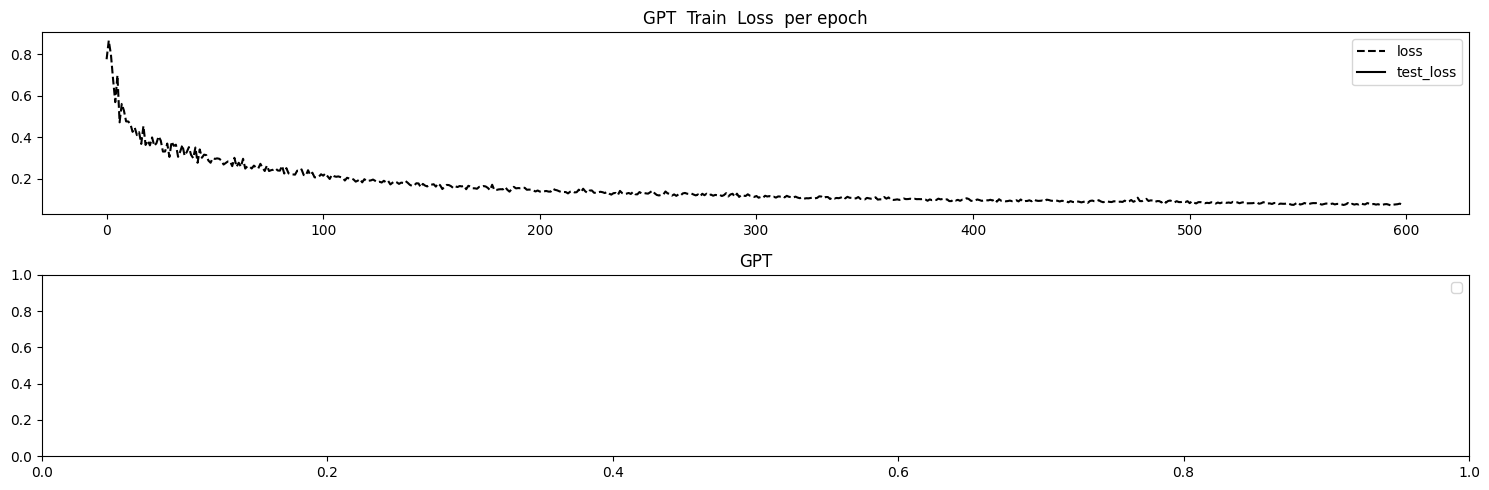

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
max tokens  14
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
logits
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
logits
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
logits
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
logits
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
logits
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
logits
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
lo

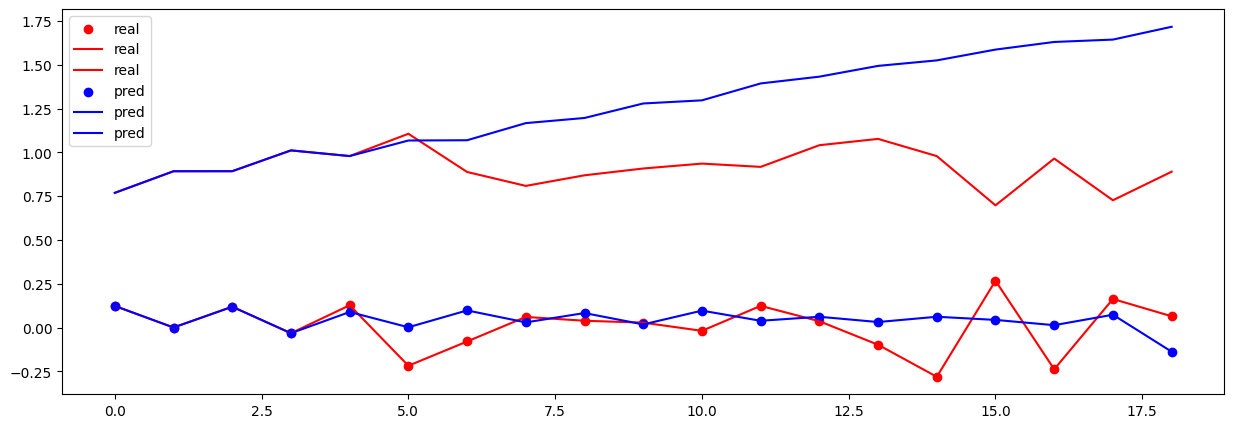

(100, 25)
119
19


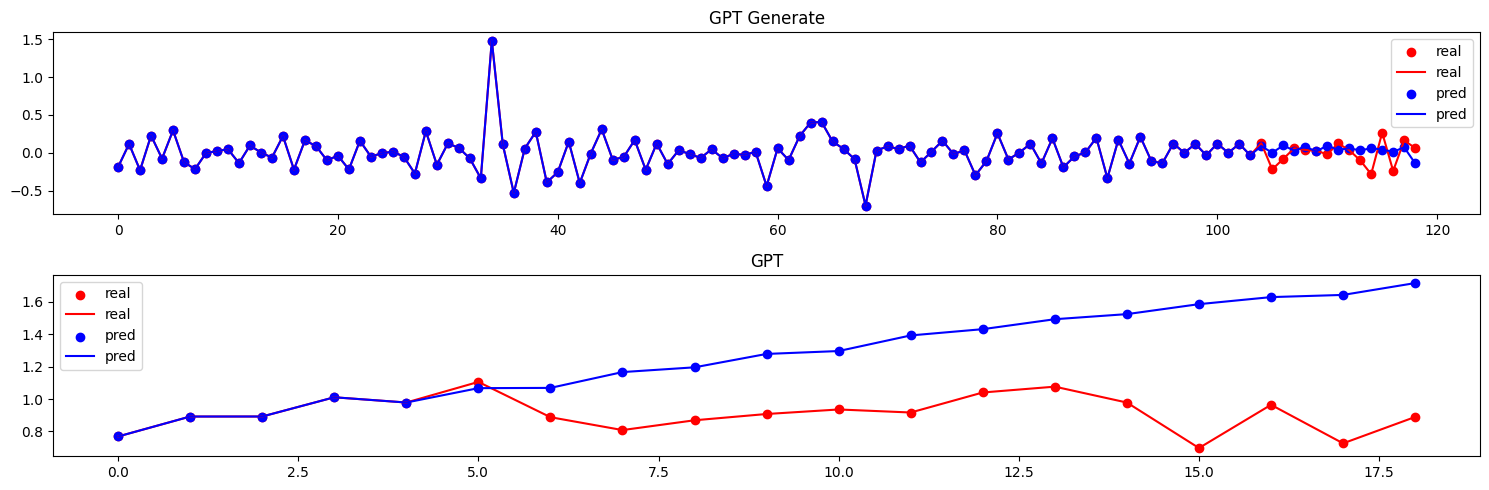

In [80]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


torch.Size([200, 25])
0 train loss =  0.8482173085212708
500 train loss =  0.12250235676765442


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


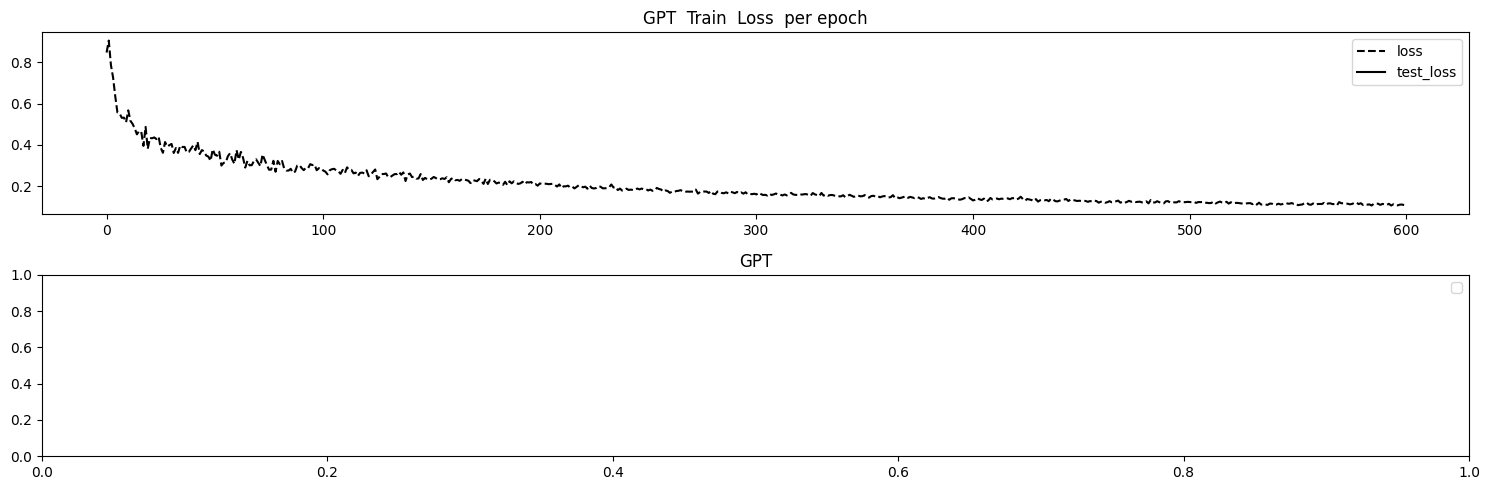

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
max tokens  14
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
logits
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
logits
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
logits
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
logits
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
logits
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
logits
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
lo

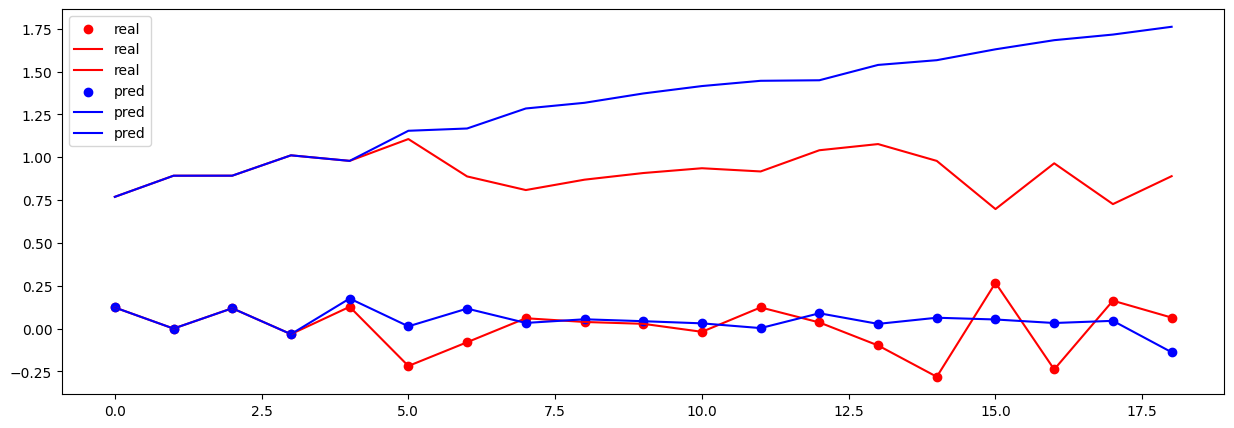

(200, 25)
219
19


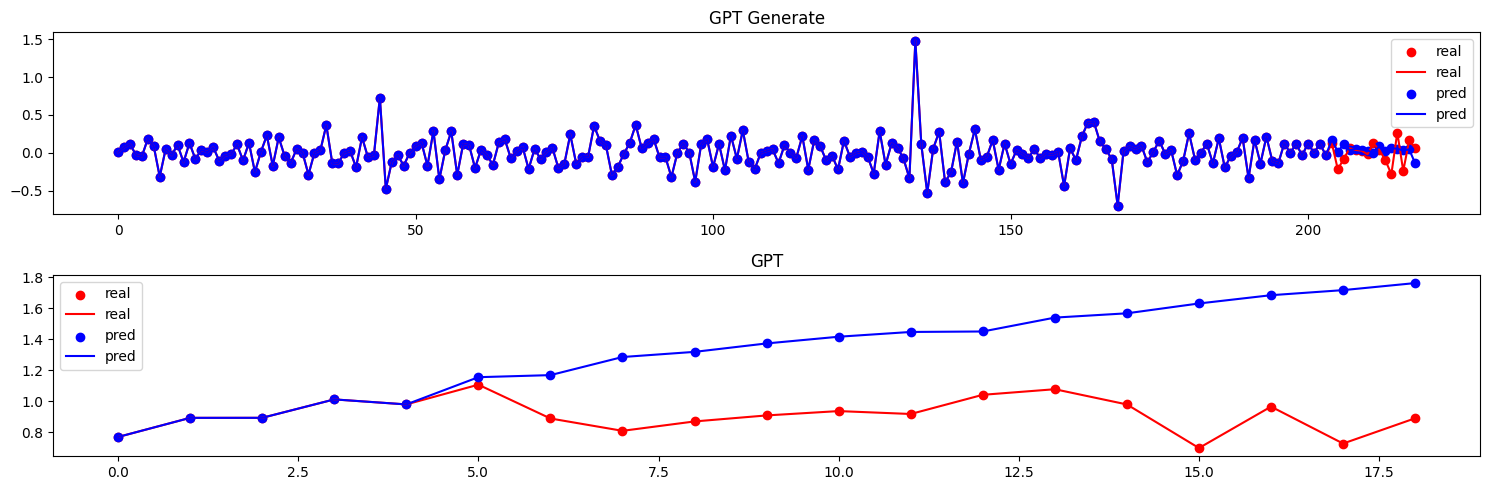

In [81]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
max tokens  14
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
logits
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
logits
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
logits
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
logits
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
logits
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
logits
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
lo

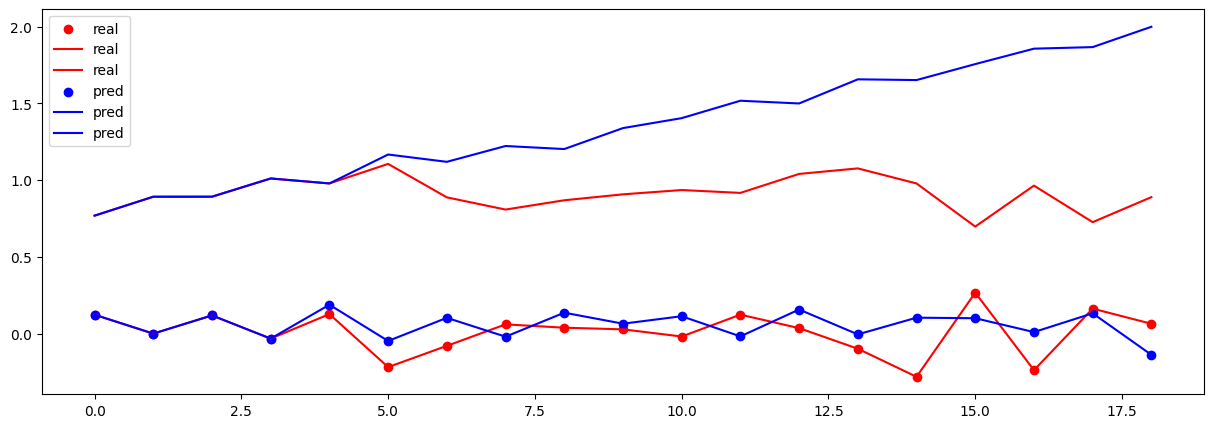

(200, 25)
219
19


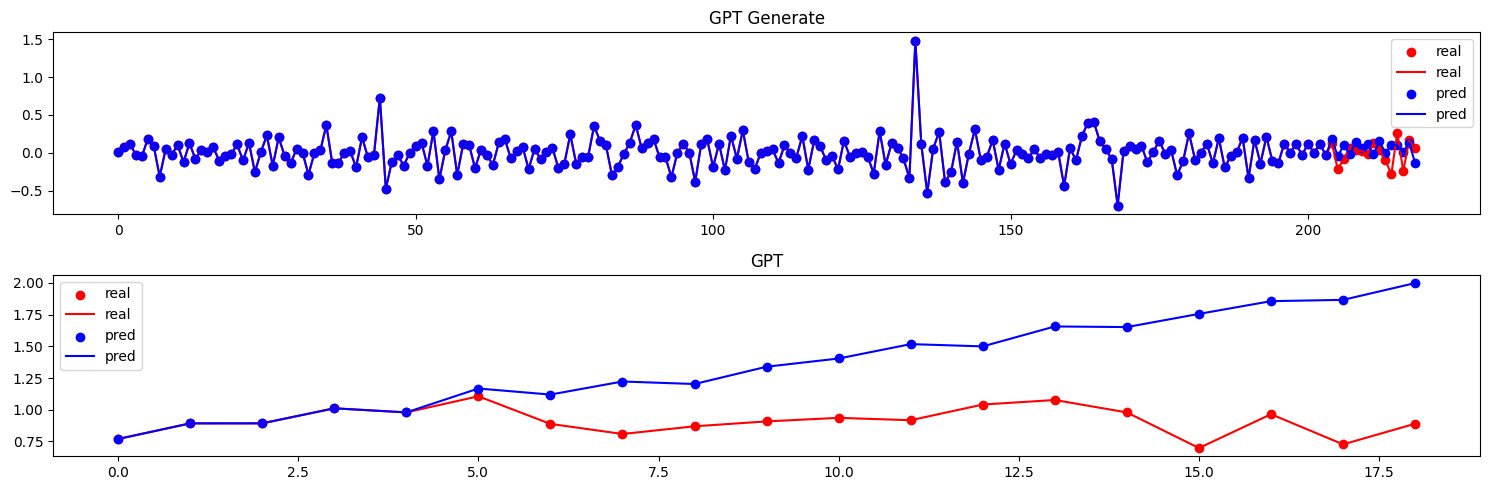

In [82]:

function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


torch.Size([300, 25])
0 train loss =  0.8246868252754211
500 train loss =  0.15668977797031403


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


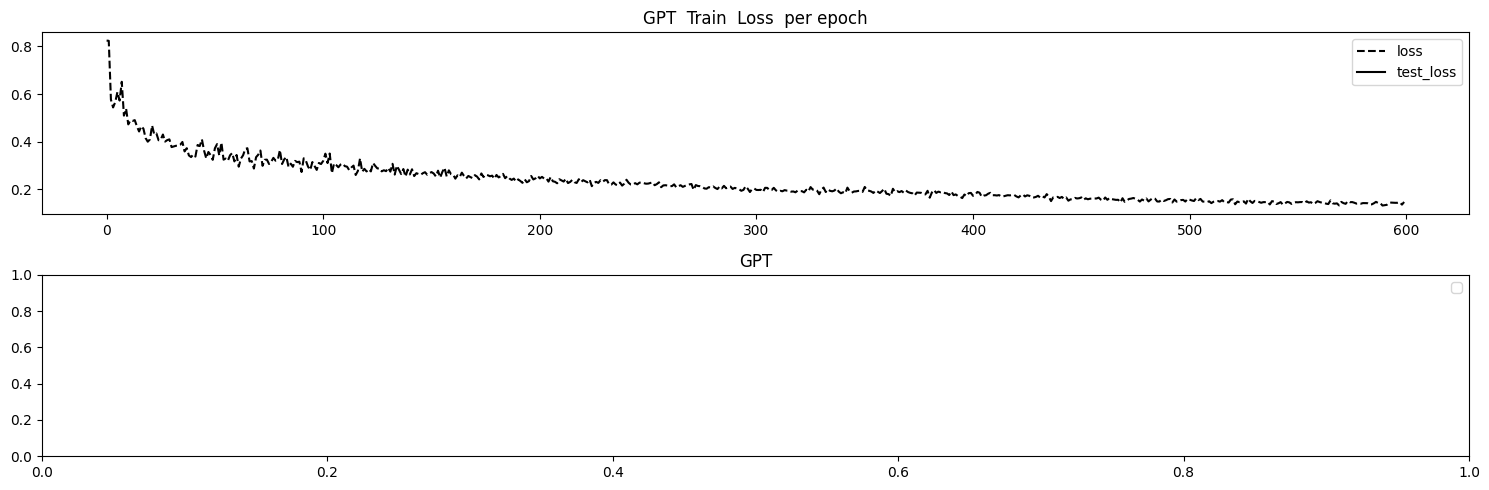

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
max tokens  14
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
logits
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
logits
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
logits
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
logits
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
logits
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
logits
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
concat added the new pred
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
lo

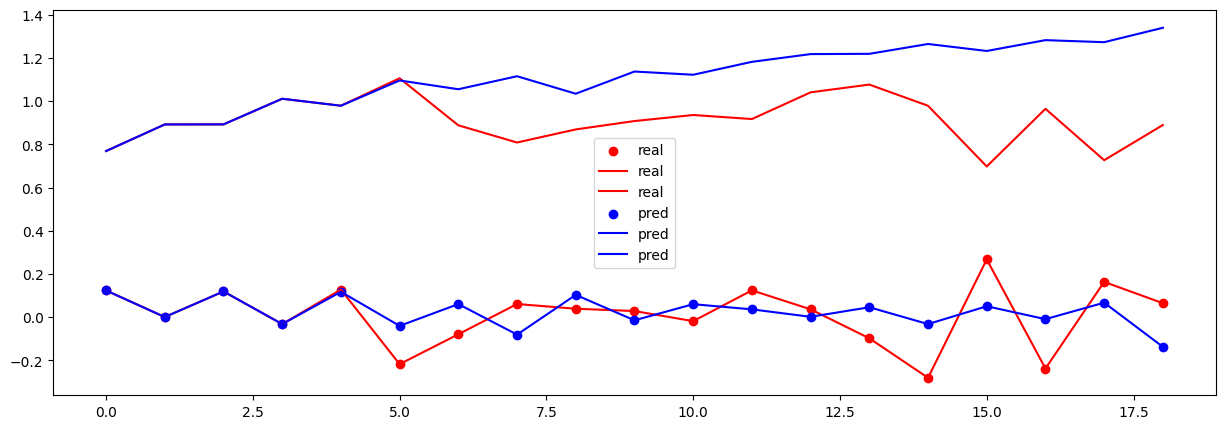

(300, 25)
319
19


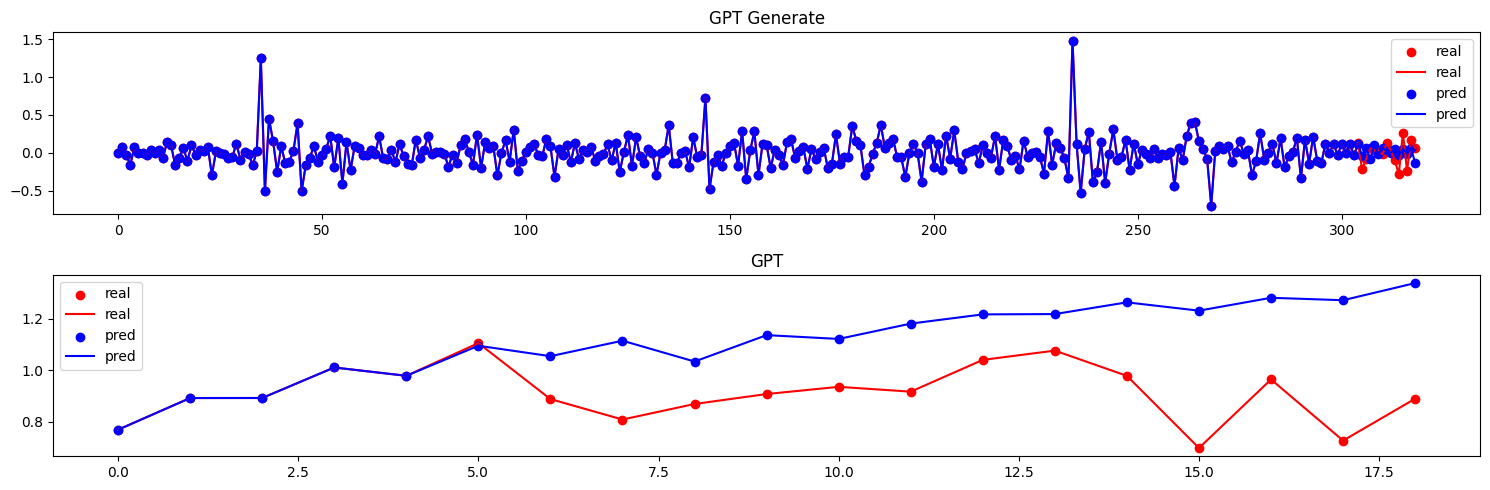

In [83]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


In [84]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


torch.Size([400, 25])
0 train loss =  0.7918277978897095


KeyboardInterrupt: 


## Run 2


In [ ]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ]  


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )





In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



## Run 3


In [ ]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



## Run 4


In [ ]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



## Run 5


In [ ]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



## Run 6


In [ ]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


In [ ]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )
